# [SS60] Walmart TripType Classification

https://ko.coursera.org/lecture/competitive-data-science/walmart-trip-type-classification-CMcdq

# 0. Settings

In [68]:
# import *
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
import scipy as sp
import scipy.stats
import statsmodels.api as sm
import sklearn as sk

import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.font_manager as fm
font_location = "/Library/Fonts/AppleGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
print(font_name)
mpl.rc('font', family=font_name)
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

AppleGothic


In [65]:
# 메모리 절약
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [66]:
# 데이터 불러오기
df = import_data("train.csv")
df_test = import_data("test.csv")

Memory usage of dataframe is 34.56 MB
Memory usage after optimization is: 9.26 MB
Decreased by 73.2%
Memory usage of dataframe is 29.92 MB
Memory usage after optimization is: 8.11 MB
Decreased by 72.9%


# 1. About Dataset
## 1.1 개요

In [4]:
# 데이터 모양
df.shape, df_test.shape

((647054, 7), (653646, 6))

In [5]:
# 각 변수의 데이터 수
df.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

In [6]:
# 누락값 체크
num_rows = df.shape[0]
num_missing = num_rows - df.count()
num_missing

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

## 1.2 Column 살펴보기
### 1.2.1 `TripType` 
- 고객의 구매 활동을 나타내는 카테고리컬 식별값. 
- 이번 분석에서의 Target값

In [7]:
# TripType
# 다른 변수들을 분석해 38가지 중에 하나로 분류해야 합니다. 
# 999번은 '기타'값입니다.
print(df.TripType.unique())
print("{}가지 ID가 있습니다.".format(len(df.TripType.unique())))

[999  30  26   8  35  41  21   6  42   7   9  39  25  38  15  36  20  37
  32  40   5   3   4  24  33  43  31  27  34  18  29  44  19  23  22  28
  14  12]
38가지 ID가 있습니다.


### 1.2.2 `VisitNumber`
- 단일 고객의 단일 구매 활동을 나타내는 값
- 95674가지 값을 가집니다.

In [8]:
len(df.VisitNumber.unique())

95674

In [9]:
df.VisitNumber.unique()

array([     5,      7,      8, ..., 191345, 191346, 191347])

### 1.2.3 `Weekday` 
- `VisitNumber`가 일어난 요일

In [10]:
df.Weekday.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

### 1.2.4 `Upc`
- Universal Product Code. 구매한 제품의 고유값
- 97715개 상품이 팔렸습니다.

In [11]:
len(df.Upc.unique())

97715

### 1.2.5 `ScanCount`
- 해당 상품을 몇 개 샀는지를 나타냄.
- 반품했을 경우 음수값으로 표시

In [12]:
print(df.ScanCount.unique())
print(df.ScanCount.describe())

[ -1   1   2   3   5   6   4  14  -2   9   7  10   8  -3  -5  11  16  -4
  13  15  30  -6  12  20 -12  19  46  23  -7  22  25  24  31  -9  51  17
  18  71 -10]
count    647054.000000
mean          1.108878
std           0.700776
min         -12.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          71.000000
Name: ScanCount, dtype: float64


### 1.2.6 `DepartmentDescription` 
- 상품 대분류
- 이 기준에 따르면 상품들은 69가지로 분류됩니다.

In [13]:
print(len(df.DepartmentDescription.unique()))
print(df.DepartmentDescription.unique())

69
['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS'
 'CELEBRATION' 'HARDWARE' 'BEAUTY' 'AUTOMOTIVE' 'BOOKS AND MAGAZINES'
 'SEAFOOD' 'OFFICE SUPPLIES' 'LAWN AND GARDEN' 'SHEER HOSIERY' 'WIRELESS'
 'BEDDING' 'BATH AND SHOWER' 'HORTICULTURE AND ACCESS' 'HOME DECOR' 'TOYS'
 'INFANT APPAREL' 'LADIES SOCKS' 'PLUS AND MATERNITY' 'ELECTRONICS'
 'GIRLS WEAR, 4-6X  AND 7-14' 'BRAS & SHAPEWEAR' 'LIQUOR,WINE,BEER'
 'SLEEPWEAR/FOUNDATIONS' 'CAMERAS AND SUPPLIES' 'SPORTING GOODS'
 'PLAYERS AND ELECTRONICS' 'PHARMACY RX' 'MENSWEAR' 'OP

In [14]:
df[df.DepartmentDescription == 'SHOES'].count()

TripType                 6099
VisitNumber              6099
Weekday                  6099
Upc                      6099
ScanCount                6099
DepartmentDescription    6099
FinelineNumber           6099
dtype: int64

In [15]:
df[df.DepartmentDescription == 'CAMERAS AND SUPPLIES'].count()

TripType                 221
VisitNumber              221
Weekday                  221
Upc                      221
ScanCount                221
DepartmentDescription    221
FinelineNumber           221
dtype: int64

In [16]:
df[df.DepartmentDescription == 'FINANCIAL SERVICES'].count()

TripType                 10723
VisitNumber              10723
Weekday                  10723
Upc                      10723
ScanCount                10723
DepartmentDescription    10723
FinelineNumber           10723
dtype: int64

### 1.2.7 `FinelineNumber` 
- 월마트가 자체적으로 사용하는 세분화된 상품 분류 코드
- 이 기준에 따르면 상품들은 51965가지로 분류됩니다.

In [17]:
len(df.FinelineNumber.unique())
print(df.FinelineNumber.unique())

[1000. 8931. 4504. ... 8257. 4314. 7130.]


## 1.3 데이터 예시

In [18]:
# 0번 데이터
df.iloc[0]

TripType                                999
VisitNumber                               5
Weekday                              Friday
Upc                             6.81132e+10
ScanCount                                -1
DepartmentDescription    FINANCIAL SERVICES
FinelineNumber                         1000
Name: 0, dtype: object

- VisitNumber 5번에서
- 금요일에 물건 '6.81132e+10'이 하나 팔렸다가 환불됐다. 
- 분류는 FINANCIAL SERVICES이고 월마트 분류기준 1000번이다
- 트립타입은 999(기타)로 분류됐다

In [19]:
# 1번 데이터
df.iloc[1]

TripType                          30
VisitNumber                        7
Weekday                       Friday
Upc                      6.05388e+10
ScanCount                          1
DepartmentDescription          SHOES
FinelineNumber                  8931
Name: 1, dtype: object

- VisitNumber 7번에서
- 금요일에 물건 '6.05388e+10'이 하나 팔렸다. 
- 분류는 SHOES이고 월마트 분류기준 8931번이다.
- 트립타입은 30으로 분류됐다

## 2. EDA와 전처리
### 2.1 `Weekday` 인코딩

In [72]:
weekday = {"Monday": 0, 
           "Tuesday": 1, 
           "Wednesday": 2, 
           "Thursday": 3, 
           "Friday": 4, 
           "Saturday": 5, 
           "Sunday": 6}
df["Weekday"] = df["Weekday"].apply(lambda x: weekday[x])
df_test["Weekday"] = df_test["Weekday"].apply(lambda x: weekday[x])

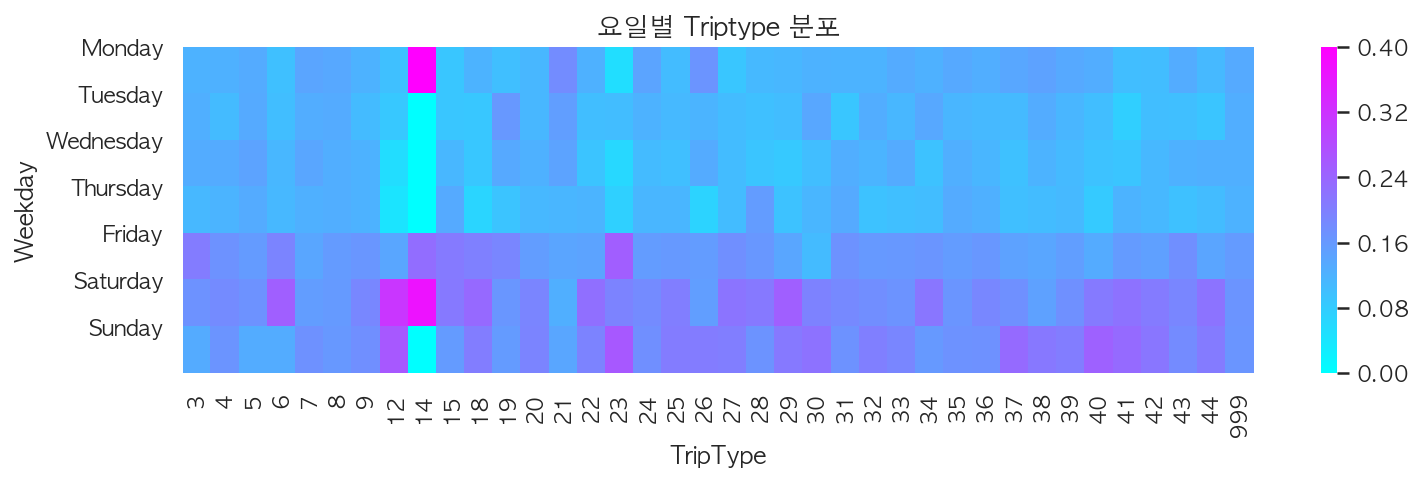

In [37]:
plt.figure(figsize=(12, 3))
sns.heatmap(data=pd.crosstab(df["Weekday"],
                             df["TripType"], 
                             values=df["VisitNumber"],
                             aggfunc='count', 
                             normalize="columns"), cmap="cool")
plt.yticks(range(0,7), list(weekday.keys()), rotation="horizontal")
plt.title("요일별 Triptype 분포", fontsize=13)
plt.show()

### 2.2 `Upc` 누락값 처리

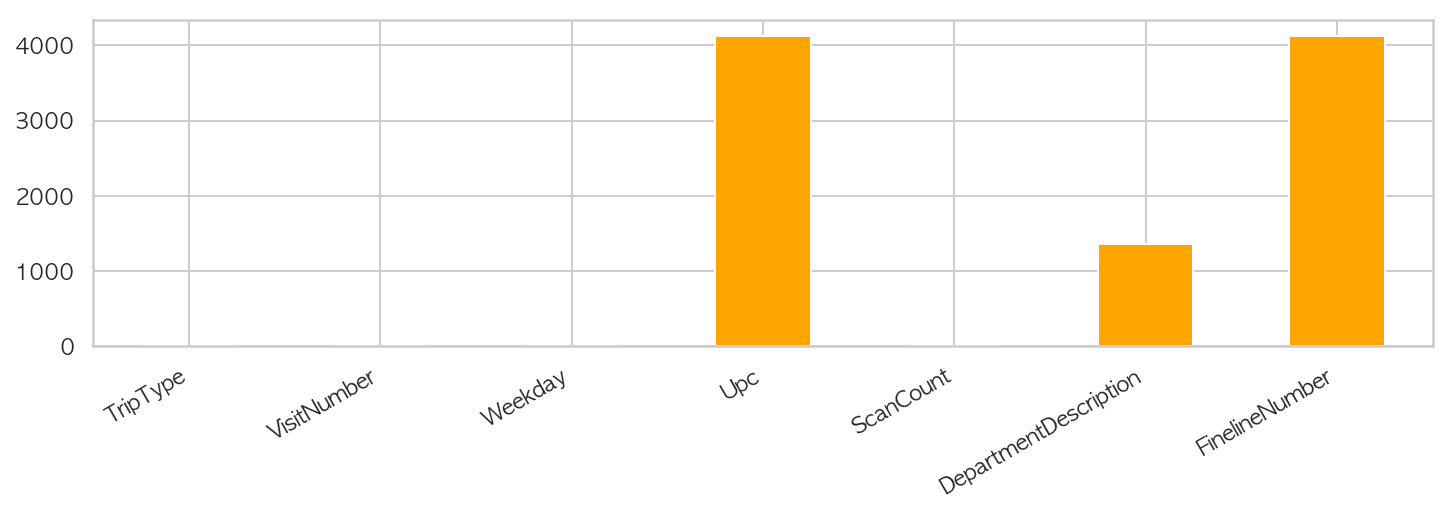

In [38]:
plt.figure(figsize=(12, 3))
df.isnull().sum().plot(kind='bar', color="orange")
plt.xticks(rotation=30, ha='right')
plt.show()

In [73]:
# nan값을 0으로 변경
df['Upc'] = df['Upc'].fillna(0)
df_test['Upc'] = df_test['Upc'].fillna(0)

### 2.3 `Upc` 정수 모양의 문자로 변경

In [74]:
def upc(num):
    while num != "nan":
        num = str(num).split(".")[0]
        return num

In [75]:
df['Upc'] = df['Upc'].apply(upc)
df_test['Upc'] = df_test['Upc'].apply(upc)

### 2.4 `Upc` 에서 회사코드 뽑아내기

In [76]:
def upc_company(x):
    try: 
        p = x[:6]
        if p == "000000":
            return x[-5]
        return p
    except:
        return -9999

In [77]:
df['Upc_company'] = df['Upc'].apply(upc_company)
df_test['Upc_company'] = df_test['Upc'].apply(upc_company)

### 2.5 `TripType` 별 카운트

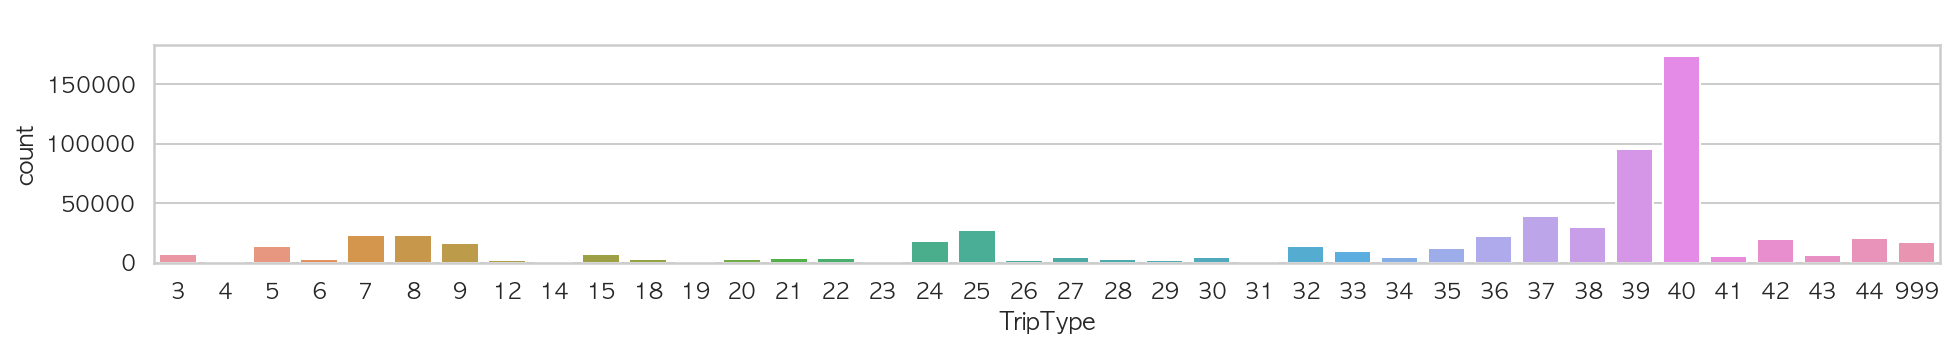

In [57]:
plt.figure(figsize=(16,2))
sns.countplot(x="TripType", data=df)
plt.title(" ")
plt.show()

### 2.6 `DepartmentDescription` 컬럼 추가

In [59]:
df.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', nan,
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',

In [78]:
dep_list = ['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',
       'LIQUOR,WINE,BEER', 'SLEEPWEAR/FOUNDATIONS',
       'CAMERAS AND SUPPLIES', 'SPORTING GOODS',
       'PLAYERS AND ELECTRONICS', 'PHARMACY RX', 'MENSWEAR',
       'OPTICAL - FRAMES', 'SWIMWEAR/OUTERWEAR', 'OTHER DEPARTMENTS',
       'MEDIA AND GAMING', 'FURNITURE', 'OPTICAL - LENSES', 'SEASONAL',
       'LARGE HOUSEHOLD GOODS', '1-HR PHOTO', 'CONCEPT STORES',
       'HEALTH AND BEAUTY AIDS']
dep_list.sort()

In [79]:
for i in range(len(dep_list)):
    df['dep_{}'.format(dep_list[i])] = df["DepartmentDescription"].apply(lambda x : 1 if x == dep_list[i] else 0)
    df_test['dep_{}'.format(dep_list[i])] = df_test["DepartmentDescription"].apply(lambda x : 1 if x == dep_list[i] else 0)

In [69]:
# 아래 코드
df_d_sum = df.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['ScanCount'].agg('sum').sort_values(['VisitNumber', 'ScanCount', 'DepartmentDescription'], ascending=[1, 0, 1])
df_d_sum['abs_sum'] = df_d_sum.assign(abs=df_d_sum['ScanCount'].abs()).groupby(['VisitNumber'])['abs'].transform('sum')

df_test_d_sum = df_test.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['ScanCount'].agg('sum').sort_values(['VisitNumber', 'ScanCount', 'DepartmentDescription'], ascending=[1, 0, 1])
df_test_d_sum['abs_sum'] = df_test_d_sum.assign(abs=df_d_sum['ScanCount'].abs()).groupby(['VisitNumber'])['abs'].transform('sum')

# change 'abs_sum' for div
criteria = df_d_sum['abs_sum'] == 0
df_d_sum.loc[criteria, 'abs_sum'] = 999

criteria_test = df_test_d_sum['abs_sum'] == 0
df_test_d_sum.loc[criteria_test, 'abs_sum'] = 999

# create ratio
df_d_sum['ratio'] = df_d_sum['ScanCount'] / df_d_sum['abs_sum']
df_test_d_sum['ratio'] = df_test_d_sum['ScanCount'] / df_d_sum['abs_sum']

# abs_sum 원복
criteria = df_d_sum['abs_sum'] == 999
df_d_sum.loc[criteria, 'abs_sum'] = 0

criteria_test = df_test_d_sum['abs_sum'] == 999
df_test_d_sum.loc[criteria_test, 'abs_sum'] = 0

# Dept Na 였던 VisitNumber append
diff = set(df.VisitNumber) - set(df_d_sum.VisitNumber)
df_d_sum = df_d_sum.append(pd.DataFrame({'VisitNumber': list(diff)},)).fillna({'DepartmentDescription': 'Na',
                                                                          'ScanCount': 0,
                                                                         'ratio':0 })

diff = set(df_test.VisitNumber) - set(df_test_d_sum.VisitNumber)
df_test_d_sum = df_test_d_sum.append(pd.DataFrame({'VisitNumber': list(diff)},)).fillna({'DepartmentDescription': 'Na',
                                                                          'ScanCount': 0,
                                                                         'ratio':0 })

# create pivot table
df_pivot = df_d_sum.pivot(index='VisitNumber', columns='DepartmentDescription', values='ratio').fillna(0)
df_pivot = pd.merge(df_pivot, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')

df_test_pivot = df_test_d_sum.pivot(index='VisitNumber', columns='DepartmentDescription', values='ratio').fillna(0)
df_test_pivot = pd.merge(df_test_pivot, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')


# make training data
X = df_pivot.iloc[:, :-1]
y = df_pivot.iloc[:, -1]

X_test = df_test_pivot.iloc[:, -1]
y_test = df_test_pivot.iloc[:, -1]

In [ ]:

# training
mod2 = RandomForestClassifier(n_estimators=200, bootstrap=False, min_samples_leaf=1, min_samples_split=3,\
                             criterion='gini').fit(X_t, y_t)

print(classification_report(y_te, mod2.predict(X_te)))